## Get the id of a grid when you input a specific latitude and longitude

In [2]:
import grids

# Get grid cell for a coordinate
lat, lon = 19.4326, -99.1332  # Mexico City coordinates
cell_id = grids.get_grid_cell(lat, lon, cell_size=500) # 500x500 m grid
cell_id

(1658, 5600)

## Get the bottom left and top right corner coordinates of a cell

In [3]:
# Get the bounds of the cell
bounds = grids.get_cell_bounds(cell_id)
print(f"Cell bounds in EPSG:6372: {bounds}")

Cell bounds in EPSG:6372: (2800000, 829000, 2800500, 829500)


## Plotting
Use the Mexico shapefile to plot grids. Also includes an example to colour a specific grid a specific colour. The grid corresponding to the coordinates of Mexico city is coloured red.<br>
Since plotting takes a really long time at 500x500 m resolution, I use 10,000 m as an example here. Adjust the `cell_size` parameter as needed.

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the shapefile
world = gpd.read_file('World_Countries_(Generalized)/World_Countries_Generalized.shp')

# Ensure the shapefile is in WGS 84
if world.crs != 'EPSG:6372':
    world = world.to_crs(epsg=6372)


mexico = world[world['COUNTRY'] == 'Mexico']

Cell bounds in EPSG:6372: (2800000, 820000, 2810000, 830000)


100%|██████████| 318/318 [00:01<00:00, 181.62it/s]


Starting clipping
Done clipping
Plotting Mexico
Plotting grid


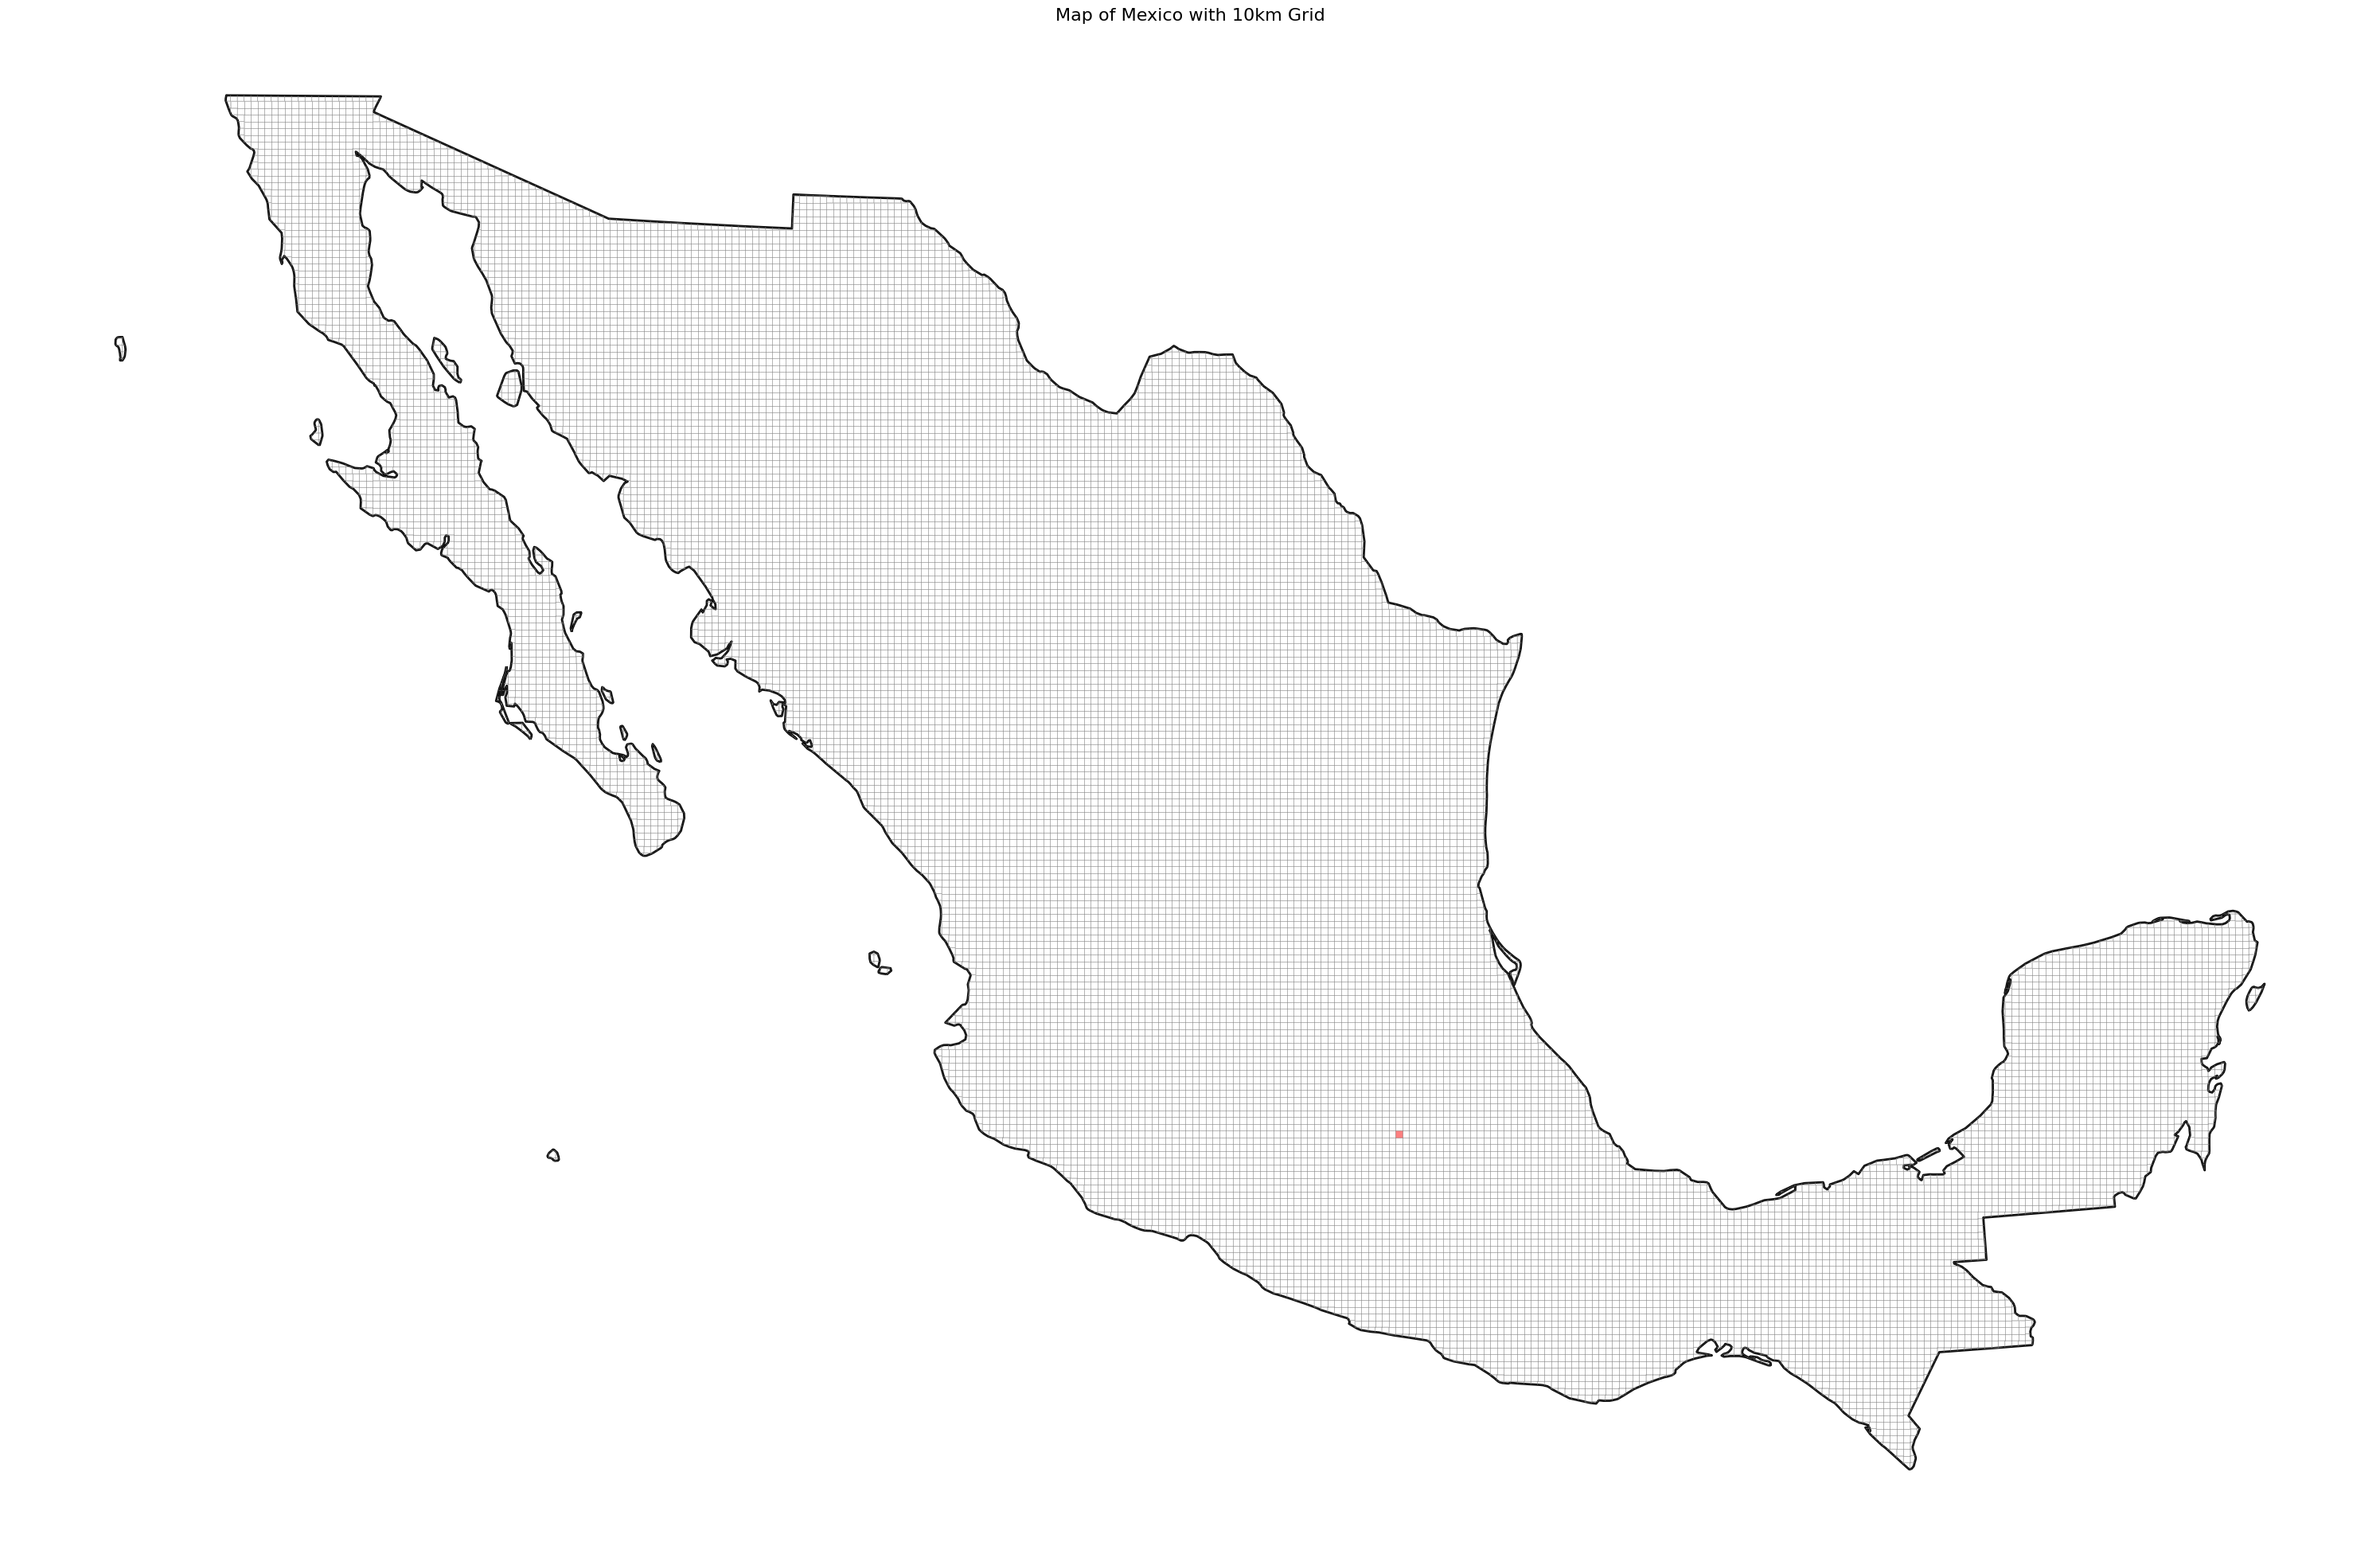

In [5]:
import numpy as np
from tqdm import tqdm
from shapely.geometry import box

cell_size = 10000  # meters

# Get grid cell for a coordinate
lat, lon = 19.4326, -99.1332  # Mexico City coordinates
cell_id = grids.get_grid_cell(lat, lon, cell_size=cell_size)

# Get the bounds of the cell
bounds = grids.get_cell_bounds(cell_id, cell_size=cell_size)
print(f"Cell bounds in EPSG:6372: {bounds}")


# Convert Mexico to UTM coordinates
mexico_crs = mexico.to_crs(epsg=6372)

# Get the bounds of Mexico in UTM coordinates
minx, miny, maxx, maxy = mexico_crs.total_bounds

# Create grid cells of 10km
x_coords = np.arange(minx, maxx, cell_size)
y_coords = np.arange(miny, maxy, cell_size)

# Specify the coordinates of the cell you want to highlight
target_x = bounds[0],   # Replace with your desired x coordinate
target_y = bounds[1]  # Replace with your desired y coordinate

# Create grid cells with color information
grid_cells = []
cell_colors = []
for x in tqdm(x_coords):
    for y in y_coords:
        cell = box(x, y, x + cell_size, y + cell_size)
        grid_cells.append(cell)
        
        # Check if this is the target cell
        if (target_x is not None and target_y is not None and 
            x <= target_x < x + cell_size and 
            y <= target_y < y + cell_size):
            cell_colors.append('red')  # You can change this color
        else:
            cell_colors.append('none')

# Create GeoDataFrame from grid with color information
grid = gpd.GeoDataFrame({
    'geometry': grid_cells,
    'color': cell_colors
}, crs=mexico_crs.crs)

print("Starting clipping")
# Clip grid to Mexico's boundary
grid_clipped = gpd.clip(grid, mexico_crs)
print("Done clipping")

# Create the plot
fig, ax = plt.subplots(figsize=(30, 20))

# Plot Mexico
print("Plotting Mexico")
mexico_crs.plot(ax=ax, color='white', edgecolor='black', linewidth=2)

# Plot grid with colors
print("Plotting grid")
# Plot cells with no color (transparent)
transparent_cells = grid_clipped[grid_clipped['color'] == 'none']
transparent_cells.plot(ax=ax, facecolor='none', edgecolor='grey', alpha=0.5, linewidth=0.5)

# Plot colored cells
colored_cells = grid_clipped[grid_clipped['color'] != 'none']
if not colored_cells.empty:
    colored_cells.plot(ax=ax, facecolor=colored_cells['color'], edgecolor='grey', alpha=0.5, linewidth=0.5)

# Customize the plot
plt.title('Map of Mexico with 10km Grid', fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()